In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns

In [2]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn')

In [3]:
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold
from sklearn.base import clone
from sklearn.preprocessing import scale

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
train_data = pd.read_csv('data\\train.csv')
test_data = pd.read_csv('data\\test.csv')

In [6]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [9]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
def clean(Original_DF):
    DF = Original_DF.copy()
    
    age_map = [int(DF[DF.Pclass==c].Age.mean()) for c in range(1, 4)]
    for c in range(1, 4):
        DF.loc[
            DF.Age.isnull() & (DF.Pclass==c), 'Age'
        ] = age_map[c-1]
    DF['Age'] = DF.Age.astype(int)
    
    sex_mapping = {'male': 1, 'female': 0}
    DF['Sex'] = DF.Sex.map(sex_mapping)
    
    Fare_map = [int(DF[DF.Pclass==c].Fare.mean()) for c in range(1, 4)]
    for c in range(1, 4):
        DF.loc[
            DF.Fare.isnull() & (DF.Pclass==c), 'Fare'
        ] = Fare_map[c-1]
    
    
    DF.Pclass = DF.Pclass.fillna(0)
    
    DF['Alone'] = DF.SibSp + DF.Parch == 0
    DF['Alone'] = DF.Alone.astype(int)
    
    DF['Embarked'] = DF.Embarked.fillna('S')
    Embarked_map = {'S': 0, 'C': 1, 'Q': 2}    
    DF['Embarked'] = DF.Embarked.map(Embarked_map).astype(int)
    
    DF['Cabin'] = DF.Cabin.map(lambda c: 0 if type(c) == float else 1)
    
    
    features = ['Pclass', 'Sex', 'Age', 'Alone', 'Fare', 'Embarked', 'Cabin']
    
    return DF[features]

In [11]:
def clean2(Original_DF):
    DF = Original_DF.copy()
    
    DF['Title'] = DF.Name.str.extract(' ([A-Za-z]+)\.', expand = False)
    DF['Title'] = DF['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    DF['Title'] = DF['Title'].replace('Mlle', 'Miss')
    DF['Title'] = DF['Title'].replace('Ms', 'Miss')
    DF['Title'] = DF['Title'].replace('Mme', 'Mrs')    
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    DF['Title'] = DF.Title.map(title_mapping)
    DF['Title'] = DF.Title.fillna(0)
    
    
    sex_mapping = {'male': 1, 'female': 0}
    DF['Sex'] = DF.Sex.map(sex_mapping)
    
    
    age_map = [int(DF[DF.Pclass==c].Age.mean()) for c in range(1, 4)]
#     DF.Age = DF.Age.fillna(-100)
    for c in range(1, 4):
        DF.loc[
            DF.Age.isnull() & (DF.Pclass==c), 'Age'
        ] = age_map[c-1]
    DF['Age'] = DF.Age.apply(lambda n: int(n/16))
    DF['Age'] = DF.Age.astype(int)
    
    DF['Family'] = DF.SibSp + DF.Parch + 1
    
    DF['Alone'] = DF.Family == 1
    DF['Alone'] = DF.Alone.astype(int)
    
    DF['Age*Class'] = DF.Age * DF.Pclass
    
    DF['Embarked'] = DF.Embarked.fillna('S')
    Embarked_map = {'S': 0, 'C': 1, 'Q': 2}    
    DF['Embarked'] = DF.Embarked.map(Embarked_map).astype(int)
    
    
    DF['Fare'] = DF.Fare.fillna(DF.Fare.median())
    DF['FareBand'] = DF.Fare
    Fare_map = [(0, 7.91), (1, 14.454), (2, 31), (3, float('inf'))]
    Fare_map.reverse()
    for v, f in Fare_map:
        DF.loc[DF.Fare <= f, 'FareBand'] = v
    DF['Fare'] = DF.FareBand.astype(int)
    
    DF['Cabin'] = DF.Cabin.map(lambda c: 0 if type(c) == float else 1)
    
    
    
    
#     DF = DF.drop(['PassengerId', 'Name', 'Cabin', 'Ticket', 'Parch', 'SibSp', 'Family'], axis = 1)
    DF = DF[['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 
             'Embarked', 'Title', 'Alone', 'Cabin']]
    return DF
    
    

In [12]:
Z = clean2(train_data)
Z.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,Alone,Cabin
0,0,3,1,1,0,0,1,0,0
1,1,1,0,2,3,1,3,0,1
2,1,3,0,1,1,0,2,1,0
3,1,1,0,2,3,0,3,0,1
4,0,3,1,2,1,0,1,1,0


In [13]:
Z.corr()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,Alone,Cabin
Survived,1.000000,-0.338481,-0.543351,-0.024992,0.295875,0.106811,0.407753,-0.203367,0.316912
Pclass,-0.338481,1.000000,0.131900,-0.417886,-0.628459,0.045702,-0.173929,0.135207,-0.725541
Sex,-0.543351,0.131900,1.000000,0.083420,-0.248940,-0.116569,-0.502713,0.303646,-0.140391
Age,-0.024992,-0.417886,0.083420,1.000000,0.143442,-0.058497,-0.061521,0.139821,0.293697
Fare,0.295875,-0.628459,-0.248940,0.143442,1.000000,-0.091096,0.341665,-0.568942,0.497108
Embarked,0.106811,0.045702,-0.116569,-0.058497,-0.091096,1.000000,0.045400,0.017807,0.013774
Title,0.407753,-0.173929,-0.502713,-0.061521,0.341665,0.045400,1.000000,-0.405813,0.133390
Alone,-0.203367,0.135207,0.303646,0.139821,-0.568942,0.017807,-0.405813,1.000000,-0.158029
Cabin,0.316912,-0.725541,-0.140391,0.293697,0.497108,0.013774,0.133390,-0.158029,1.000000


In [14]:
# for c in range(1, 4):
#     t = Z[Z.Pclass == c]
#     tablo('Embarked', t)

In [15]:
pd.crosstab(Z.Title, Z.Survived)

Survived,0,1
Title,,
1,436,81
2,55,130
3,26,100
4,17,23
5,15,8


In [16]:
P = clean(train_data)
P['Survived'] = train_data.Survived
X_test = clean(test_data)

In [17]:
P.head()

,Pclass,Sex,Age,Alone,Fare,Embarked,Cabin,Survived
0,3,1,22,0,7.2500,0,0,0
1,1,0,38,0,71.2833,1,1,1
2,3,0,26,1,7.9250,0,0,1
3,1,0,35,0,53.1000,0,1,1
4,3,1,35,1,8.0500,0,0,0


In [18]:
P.describe()

,Pclass,Sex,Age,Alone,Fare,Embarked,Cabin,Survived
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,0.647587,29.236813,0.602694,32.204208,0.361392,0.228956,0.383838
std,0.836071,0.477990,13.220219,0.489615,49.693429,0.635673,0.420397,0.486592
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,22.000000,0.000000,7.910400,0.000000,0.000000,0.000000
50%,3.000000,1.000000,26.000000,1.000000,14.454200,0.000000,0.000000,0.000000
75%,3.000000,1.000000,37.000000,1.000000,31.000000,1.000000,0.000000,1.000000
max,3.000000,1.000000,80.000000,1.000000,512.329200,2.000000,1.000000,1.000000


In [19]:
P.corr()

,Pclass,Sex,Age,Alone,Fare,Embarked,Cabin,Survived
Pclass,1.000000,0.131900,-0.403989,0.135207,-0.549500,0.045702,-0.725541,-0.338481
Sex,0.131900,1.000000,0.079544,0.303646,-0.182333,-0.116569,-0.140391,-0.543351
Age,-0.403989,0.079544,1.000000,0.169739,0.121636,-0.038005,0.272662,-0.050127
Alone,0.135207,0.303646,0.169739,1.000000,-0.271832,0.017807,-0.158029,-0.203367
Fare,-0.549500,-0.182333,0.121636,-0.271832,1.000000,0.062142,0.482075,0.257307
Embarked,0.045702,-0.116569,-0.038005,0.017807,0.062142,1.000000,0.013774,0.106811
Cabin,-0.725541,-0.140391,0.272662,-0.158029,0.482075,0.013774,1.000000,0.316912
Survived,-0.338481,-0.543351,-0.050127,-0.203367,0.257307,0.106811,0.316912,1.000000


In [20]:
def tablo(feature, DF = train_data):
    df = DF[[feature, 'Survived']].groupby([feature])
    D = df.sum()
    D['Total'] = df.count()
    D['Part'] = df.mean()
    display (D)

for f in ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']:
    tablo(f)

,Survived,Total,Part
Pclass,,,
1,136,216,0.629630
2,87,184,0.472826
3,119,491,0.242363


,Survived,Total,Part
Sex,,,
female,233,314,0.742038
male,109,577,0.188908


,Survived,Total,Part
SibSp,,,
0,210,608,0.345395
1,112,209,0.535885
2,13,28,0.464286
3,4,16,0.250000
4,3,18,0.166667
5,0,5,0.000000
8,0,7,0.000000


,Survived,Total,Part
Parch,,,
0,233,678,0.343658
1,65,118,0.550847
2,40,80,0.500000
3,3,5,0.600000
4,0,4,0.000000
5,1,5,0.200000
6,0,1,0.000000


,Survived,Total,Part
Embarked,,,
C,93,168,0.553571
Q,30,77,0.389610
S,217,644,0.336957


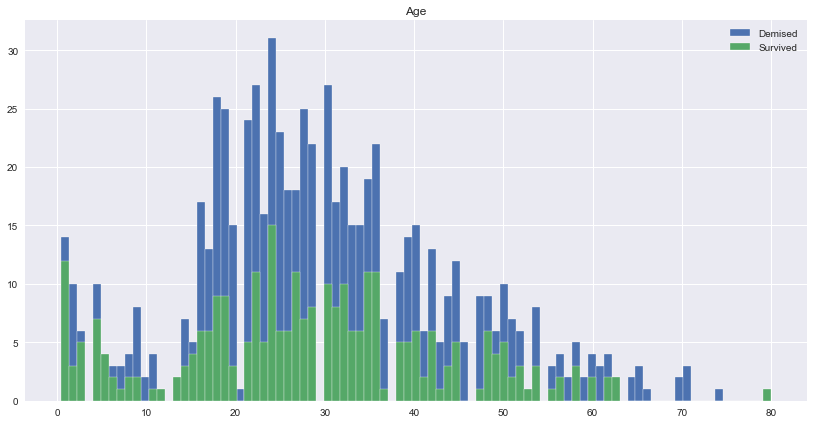

In [21]:
def histo(feature, DF = train_data):
    plt.figure(figsize = (14, 7))
    plt.hist(DF[feature], bins = len(DF[feature].unique()), 
             label = 'Demised', edgecolor = 'white')
    plt.hist(DF[DF.Survived == 1][feature], bins = len(DF[feature].unique()), 
             label = 'Survived', edgecolor = 'white')
    plt.legend()
    plt.title(feature)
    plt.show()
histo('Age')

In [22]:
tablo('Fare', Z)

,Survived,Total,Part
Fare,,,
0,44,223,0.197309
1,67,217,0.308756
2,102,229,0.445415
3,129,222,0.581081


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [24]:
# model = LogisticRegression()
# model = RandomForestClassifier()
model = SVC()
# model = KNeighborsClassifier()
# model = GaussianNB()
# model = GradientBoostingClassifier()

In [25]:
def checkaccuracy(D, model = model):
    kf = KFold()
    X = D.drop(['Survived'], axis = 1)
    Y = D.Survived
    
    A = []
    tA = []
    for traini, testi in kf.split(D):
        m = clone(model)
        trainX = X.iloc[traini]
        trainy = Y.iloc[traini]        
        trainX = pd.DataFrame(scale(trainX))

        m.fit(trainX, trainy)

        testX = X.iloc[testi]
        testy = Y.iloc[testi]
        testX = pd.DataFrame(scale(testX))
        
        a = m.score(testX, testy)
        A.append(a)
        tA.append(m.score(trainX, trainy))
        
#     print (m.feature_importances_)
#     print (sum(tA)/len(tA))
    return sum(A)/len(A)
    
print (checkaccuracy(P))
print (checkaccuracy(Z))

0.8148201619484026
0.8170359676103196


In [26]:
PAcc = []
ZAcc = []
modelnames = [
            'LogisticRegression', 
            'RandomForestClassifier', 
            'ExtraTreesClassifier',
            'AdaBoostClassifier',
            'GradientBoostingClassifier',
            'SVC', 
            'LinearSVC', 
            'KNeighborsClassifier', 
            'GaussianNB',
            'Perceptron', 
            'SGDClassifier', 
            'DecisionTreeClassifier'
                                        ]
models = [
            LogisticRegression(), 
            RandomForestClassifier(), 
            ExtraTreesClassifier(),
            AdaBoostClassifier(),
            GradientBoostingClassifier(),
            SVC(), 
            LinearSVC(), 
            KNeighborsClassifier(), 
            GaussianNB(),
            Perceptron(), 
            SGDClassifier(), 
            DecisionTreeClassifier()
                                        ]
for mod in models:
    model = clone(mod)
    p = checkaccuracy(P, model)
    z = checkaccuracy(Z, model)
    PAcc.append(p)
    ZAcc.append(z)
    
Adf = pd.DataFrame({'Models': modelnames})
Adf['P_Acc'] = PAcc
Adf['Z_Acc'] = ZAcc

print (Adf)
    

                        Models     P_Acc     Z_Acc
0           LogisticRegression  0.790120  0.785638
1       RandomForestClassifier  0.794683  0.803597
2         ExtraTreesClassifier  0.783454  0.799109
3           AdaBoostClassifier  0.782330  0.794614
4   GradientBoostingClassifier  0.813728  0.817049
5                          SVC  0.814820  0.817036
6                    LinearSVC  0.793466  0.793478
7         KNeighborsClassifier  0.789040  0.785682
8                   GaussianNB  0.743067  0.745352
9                   Perceptron  0.725146  0.713866
10               SGDClassifier  0.755364  0.754246
11      DecisionTreeClassifier  0.744266  0.790132


In [27]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [28]:
ensembles = ['RandomForest',  
            'ExtraTrees',
            'AdaBoost',
            'GradientBoosting']
emodels = [ RandomForestClassifier(**rf_params), 
            ExtraTreesClassifier(**et_params),
            AdaBoostClassifier(**ada_params),
            GradientBoostingClassifier(**gb_params)]

In [29]:
# def feature_model(DF, sc = False):
#     y = DF.Survived
#     X = DF.drop(['Survived'], axis = 1)
#     if sc:
#         X = pd.DataFrame(scale(X))
        
#     F = pd.DataFrame({'Feature': DF.drop(['Survived'], axis = 1).columns})
    
#     for name, model in zip(ensembles, emodels):
#         mod = clone(model)
#         mod.fit(X, y)
#         F[name] = mod.feature_importances_
    
#     return F

# print ('P:\n',feature_model(P, True))
# print ('Z:\n',feature_model(Z))
        

In [30]:
emodels

[RandomForestClassifier(max_depth=6, max_features='sqrt', min_samples_leaf=2,
                        n_estimators=500, n_jobs=-1, warm_start=True),
 ExtraTreesClassifier(max_depth=8, min_samples_leaf=2, n_estimators=500,
                      n_jobs=-1),
 AdaBoostClassifier(learning_rate=0.75, n_estimators=500),
 GradientBoostingClassifier(max_depth=5, min_samples_leaf=2, n_estimators=500)]

In [31]:
# def level2(DF):
#     LV = DF['Survived']
#     y = DF.Survived
#     X = DF.drop(['Survived'], axis = 1)
#     X = pd.DataFrame(scale(X)).astype(float)
    
#     for name, model in zip(ensembles, emodels):
#         mod = clone(model)
#         mod.fit(X, y)
#         LV[name] = mod.predict(X)
    
#     return LV
#     print (LV)

# print (level2(P))
# print (level2(Z))
    

In [32]:
# if 1:
#     DF = P.copy()
# # def bla(DF):
#     print((DF==P).all().all())
#     X = DF.drop(['Survived'], axis = 1)
#     for name, model in zip(ensembles, emodels):
#         mod = clone(model)
#         mod.fit(scale(X), DF.Survived)
#         print (name)
        
# bla(P)

In [33]:
model = SVC()

y_train = train_data.Survived
X_train = clean(train_data)#.drop(['Survived'], axis = 1)
X_train = pd.DataFrame(scale(X_train))

X_test = clean(test_data)
X_test = pd.DataFrame(scale(X_test))

model.fit(X_train, y_train)

SVC()

In [34]:
predictions = model.predict(X_test)
output = pd.DataFrame({'PassengerID': test_data.PassengerId, 'Survived': predictions})
output.to_csv('preds\\svc2.csv', index = False)